# Contact prediction accuracy validation

This notebook contains some useful methods for visualising the contact prediction and comparing them to a ground truth values (from PDB structures).

For this it provides tooling for:
- Deriving contact matrix from PDB structures (if residue distance < 8 angstroms)
- Deriving predicted contact matrix from Protein Residue-Residue Contacts matrices (e.g., CCMPred, GREMLIN, etc.)
- Methods for manipulating and visualising contact matrices

This code may be useful if additional contact prediction methods are used, as to allow simple comparison between them.

In [137]:
import os
import subprocess
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

from pycom import CoMAnalysis, PyCom

In [138]:
pdb_executable_path = './bin/extract_residues_from_pdb'
pdb_path = os.path.expanduser('~/pdb')

if not os.path.exists(pdb_executable_path):
    import warnings
    warnings.warn('\nextract_residues_from_pdb executable not found.\n'
                  'Please compile the C++ code and place in bin folder.\n'
                  'Requires -lz flag for zlib (and zlib needs to be installed).\n'
                  'g++ -std=c++17 extract_residues_from_pdb.cpp -lz -o bin/extract_residues_from_pdb\n')
    exit(1)
    
if not os.path.exists(pdb_path):
    import warnings
    warnings.warn('\nPDB path not found.\n'
                  'Please download from: https://www.rcsb.org/pages/download/http\n'
                  'We additionally provide a mirror at: https://pycom.brunel.ac.uk/misc/\n'
                  'Program expects the nested folder structure of the PDB database. e.g. '
                  './pdb/g5/pdb1g5j.ent.gz\n\n')
    exit(1)

In [139]:
# PyCom to contact prediction matrix
def contact_pred_from_coevolution(pd_df: pd.DataFrame):
    """
    Takes in the output of PyCom#find, with a single row
    Returns a contact prediction matrix
    """
    assert len(pd_df) == 1, 'Only one matrix at a time'
    assert 'matrix' in pd_df.columns, 'Dataframe must contain a "matrix" column'
    
    com_an = CoMAnalysis()
    scaled_mat = com_an.scale_and_normalise_coevolution_matrices(pd_df)
    mat = scaled_mat.iloc[0]['matrix_S']
    top_contacts = com_an.get_top_contacts_from_coevolution(mat)
    
    res_a = np.array(top_contacts['ResA'].values, dtype=int) - 1
    res_b = np.array(top_contacts['ResB'].values, dtype=int) - 1
    
    contact_matrix = np.eye(mat.shape[0], dtype=np.int8)
    contact_matrix[res_a, res_b] = 1
    contact_matrix[res_b, res_a] = 1
    
    return contact_matrix

In [140]:
# PDB to contact prediction matrix

IS_IN_CONTACT_THRESHOLD = 8  # max distance in angstroms, for residues to be considered in contact
IGNORE_N_ADJACENT = 5  # number of adjacent residues to ignore (0=only self-contacts are ignored, 1=1 adjacent residue is ignored, etc.)

def _get_dist_matrix_from_pdb(pdb_ent_gz_file: str, pri=False) -> np.ndarray:
    """
    Returns a distance matrix from a PDB file
    """
    assert pdb_ent_gz_file.endswith('.ent.gz'), 'File must be a .ent.gz file'
    
    # parse pdb file into list of coordinates (AA resseq x y z)
    proc = subprocess.Popen([pdb_executable_path], stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    out, _ = proc.communicate(str.encode(pdb_ent_gz_file))
    
    # convert to numpy array
    out = np.array(list(map(str.split, out.decode('UTF-8').splitlines())))
    if pri:
        for aa, ind, x, y, z in out:
            print(aa, end='')
        print()
    out = out[:, 2:].astype(float)  # trim to coordinates and convert to float
    
    return squareform(pdist(out, 'euclidean'))  # calculate pair-wise distance matrix

def _distance_to_contact_matrix(dist_matrix: np.ndarray, tril:bool = False) -> np.ndarray:
    """
    Returns a contact matrix from a distance matrix
    Contacts=1, No contacts=0, Unknown=-1
    :param dist_matrix: distance matrix
    :param tril: if True, only returns the lower triangle of the matrix (upper triangle is -1)
    """
    contact_matrix = 1 - np.heaviside(dist_matrix - IS_IN_CONTACT_THRESHOLD, 0)
    contact_matrix[np.where(np.isnan(contact_matrix))] = -1  # set nan values to -1
    contact_matrix = contact_matrix.astype(int)  # convert to int
    if tril:  # set upper triangle to -1
        contact_matrix[np.triu_indices(contact_matrix.shape[0], k=1)] = -1
    return contact_matrix

def _embed_in_larger_matrix(m: np.ndarray, length:int, offset:int=0, value: int=-1) -> np.ndarray:
    """
    Embeds a matrix in a larger matrix
    :param m: matrix to embed
    :param length: length of the larger matrix
    :param offset: offset of the matrix to embed
    :param value: value to fill the larger matrix with
    """
    assert m.shape[0] + offset <= length, 'Matrix does not fit in larger matrix'
    out = np.full((length, length), value)
    out[offset:offset+m.shape[0], offset:offset+m.shape[1]] = m
    return out

In [141]:
def _contact_accuracy_naive(a: np.ndarray, b: np.ndarray):
    """
    Calculates the accuracy of contact prediction between two contact maps.
    
    Accuracy = % of correctly predicted contacts / % of predicted contacts
    
    Predictions are only counted if:
        1. in the lower triangle of the matrix (as to not double count)
        2. both matrices made predictions at that position (i.e. not -1)
        3. predictions are not self-contacts (i.e. i != j)
    """
    x = a[np.tril_indices_from(a, -1)]
    y = b[np.tril_indices_from(b, -1)]
    return (np.sum((x == y) & (x != -1) & (y != -1)) 
            / np.sum((x != -1) & (y != -1)))


def contact_accuracy_prec(pred: np.ndarray, ref: np.ndarray, ignore_n_adjacent: int = 0):
    """
    Calculates the sensitivity and precision of contact prediction between two contact maps.
    
    Sensitivity = % of correctly predicted contacts / % of contacts in reference
    Precision = % of correctly predicted contacts / % of contacts in prediction
    
    Inputs:
        pred: predicted contact map (e.g., from CCMPred)
        ref: reference contact map (e.g., from PDB)
        ignore_n_adjacent: number of adjacent residues to ignore (default=0)
            If 0, only self-contacts are ignored (set to -1 if self-contact should be counted)
    """
    p_mat = pred[np.tril_indices_from(pred, -1 - ignore_n_adjacent)]  # ignore self-contact by default
    gt_mat = ref[np.tril_indices_from(ref, -1 - ignore_n_adjacent)]
    known_ind = (p_mat != -1) & (gt_mat != -1)
    p_contact_ind = (p_mat[known_ind] == 1)
    gt_contact_ind = (gt_mat[known_ind] == 1)
    
    sensitivity = np.sum(p_contact_ind & gt_contact_ind) / np.sum(gt_contact_ind)
    precision = np.sum(p_contact_ind & gt_contact_ind) / np.sum(p_contact_ind)
    return sensitivity, precision

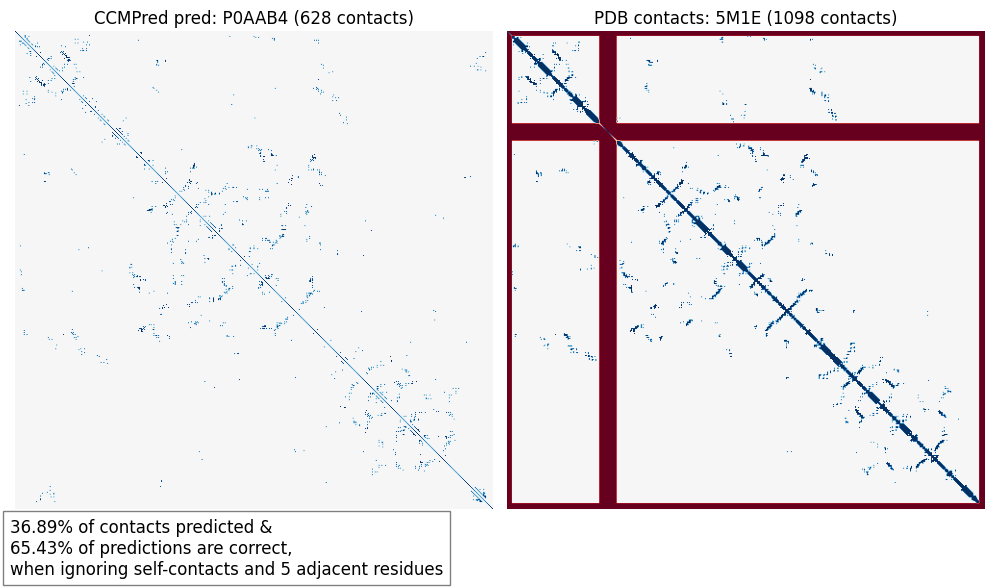

In [142]:
def process_uniprot_pdb_pair(uniprot_id: str, pdb_id: str):
    pyc = PyCom(remote=True)
    pyc_matrix = pyc.find(uniprot_id=uniprot_id, page=1, matrix=True)
    pyc_pred = contact_pred_from_coevolution(pyc_matrix)
    
    pdb_dist = _get_dist_matrix_from_pdb(f'{pdb_path}/{pdb_id[1:3]}/pdb{pdb_id}.ent.gz', pri=False)
    pdb_contact = _distance_to_contact_matrix(pdb_dist)
    pdb_contact = _embed_in_larger_matrix(pdb_contact, pyc_pred.shape[0], offset=0)
    
    cov_contact_predictions = sum(pyc_pred[np.tril_indices_from(pyc_pred, k=-1-IGNORE_N_ADJACENT)] == 1)
    pdb_contact_predictions = sum(pdb_contact[np.tril_indices_from(pdb_contact, k=-1-IGNORE_N_ADJACENT)] == 1)
    
    plt.figure(figsize=(10, 6.2))
    plt.subplot(1, 2, 1)
    plt.imshow(pyc_pred, cmap='RdBu', vmin=-1, vmax=1)
    plt.title(f'CCMPred pred: {uniprot_id} ({cov_contact_predictions} contacts)')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(pdb_contact, cmap='RdBu', vmin=-1, vmax=1)
    plt.title(f'PDB contacts: {pdb_id} ({pdb_contact_predictions} contacts)')
    plt.axis('off')
    
    plt.tight_layout()
    
    percent_of_contacts_predicted, percent_of_predicted_contacts_correct = contact_accuracy_prec(pyc_pred, pdb_contact, ignore_n_adjacent=IGNORE_N_ADJACENT)
    
    plt.figtext(0.01, 0.01,
                f"{percent_of_contacts_predicted:.2%} of contacts predicted &\n"
                f"{percent_of_predicted_contacts_correct:.2%} of predictions are correct,\n"
                f"when ignoring self-contacts and {IGNORE_N_ADJACENT} adjacent residues",
                ha="left", fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})
    
    plt.show()    
    return pyc_pred, pdb_contact

_ = process_uniprot_pdb_pair('P0AAB4', '5M1E')

## Code for generating PDB <-> Uniprot ID mapping

In [ ]:
pycom_db_path = '~/pycom.db'
if not os.path.exists(os.path.expanduser(pycom_db_path)):
    import warnings
    warnings.warn('\npycom.db not found.\n'
                  'Please download from: https://pycom.brunel.ac.uk/downloads/\n')
    exit(1)

pyc = PyCom(db_path=pycom_db_path)

def get_seq_from_pdb(pdb_ent_gz_file: str) -> str:
    assert pdb_ent_gz_file.endswith('.ent.gz'), 'File must be a .ent.gz file'
    
    proc = subprocess.Popen([pdb_executable_path], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)
    out, _ = proc.communicate(str.encode(pdb_ent_gz_file))
    
    aa = [l[0] for l in out.decode('UTF-8').splitlines()]
    return ''.join(aa)

total, correct = 0, 0

for l in open('uniprot_pdb.txt'):
    up_id, pdb_id = l.strip().split()
    pdb_id = pdb_id.lower()
    if up_id == 'uniprot_id': continue
    pyc_matrix = pyc.find(uniprot_id=up_id)
    up_seq = pyc_matrix['sequence'].iloc[0]
    
    try:
        pdb_seq = get_seq_from_pdb(f'/{pdb_path}/{pdb_id[1:3]}/pdb{pdb_id}.ent.gz')
    except:
        total += 1
        continue
    # print(list(zip(up_seq, pdb_seq)))
    match_up = all(a == b or '.' in [a, b] for a, b in zip(up_seq, pdb_seq))
    total += 1
    if match_up and len(pdb_seq) > 1:
        correct += 1
        print(up_id, pdb_id.upper())
        
print(correct, total)